In [1]:
%matplotlib inline
#
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import random as rng
import skimage
import ipywidgets as widgets
from PIL import Image, ImageDraw, ImageFont
from matplotlib.pyplot import figure, subplot
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from skimage import data, exposure, io, filters, feature, measure
from skimage.color import rgb2gray
from scipy.ndimage import zoom
from PIL import Image  
import PIL

In [2]:
class Load:
    
    def __init__(self):
        return
    
    def imgcv(file):
        img = cv.imread("../res/"+file+".jpg")
        rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        return rgb
    def imgio(file):
        img = io.imread('../res/'+file+'.jpg', 0)
        rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        return rgb

In [3]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv.LUT(image, table)

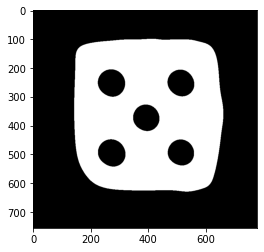

In [4]:
latwe0 = Load.imgcv("latwe0")
latwe0_grayscale = cv.cvtColor(latwe0, cv.COLOR_RGB2GRAY)

blur = skimage.filters.gaussian(latwe0_grayscale, sigma=20)
thresh = skimage.filters.threshold_otsu(blur)
mask = (blur > thresh)
latwe0_normalized = mask.astype(np.uint8)
plt.imshow(latwe0_normalized, cmap='gray')

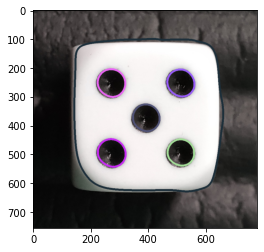

In [5]:
contours, hierarchy = cv.findContours(latwe0_normalized, cv.RETR_TREE, cv.CHAIN_APPROX_NONE) 
drawing = np.zeros((latwe0_normalized.shape[0], latwe0_normalized.shape[1], 3), dtype=np.uint8)
for i in range(len(contours)):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    cv.drawContours(latwe0, contours, i, color, 5, cv.LINE_8, hierarchy, 0)
plt.imshow(latwe0, cmap='gray')

In [6]:
max_contour = 0
oczka = []
for i in contours:
    if cv.contourArea(i) > max_contour:
        max_contour = cv.contourArea(i)
for i in contours:
    if cv.contourArea(i) != max_contour:
        oczka.append(i)

print(len(oczka))

5


In [8]:
def zoom(image,dst, x=0):

    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    blur = cv.medianBlur(gray, 5)
    sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpen = cv.filter2D(blur, -1, sharpen_kernel)
    if x == 1:
        gam = adjust_gamma(sharpen, 1.5)
        thresh = cv.threshold(gam,dst,255, cv.THRESH_BINARY)[1]
    else:
        thresh = cv.threshold(sharpen,dst,255, cv.THRESH_BINARY_INV)[1]
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
    close = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel, iterations=2)
    
    cnts = cv.findContours(close, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    min_area = 0
    max_area = 10000
    fields = []
    
    for c in cnts:
        area = cv.contourArea(c)
        fields.append(area)
    check = True

    if check:
        index = fields.index(max(fields))
        del cnts[index]
        del fields[index]
        biggest = max(fields)
        image_number = 0

    fields2 = fields.copy()
    dlugosc = len(fields2)
    i = 0
    while(i < dlugosc):
        if fields2[i] < max(fields2)//2:
            del fields2[i]
            del cnts[i]
            dlugosc-=1
        else:
            i+=1
    
    zooms = []
    coords = []
    for i, j in zip(cnts, fields2):
        if j > biggest - 10000:
            x,y,w,h = cv.boundingRect(i)
            zoom = image[y:y+h, x:x+h]
            coords.append([y+h//2, x+h//2])
            #cv.imwrite('zoom_{}.png'.format(image_number), zoom)
            #cv.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2) #rysowanie gownokwadratow
            zooms.append(zoom)
            image_number += 1
    return zooms, coords

In [8]:
#15.11.2020 edit BY JEDRZEJ!!!

In [9]:
def saveZoom(img, dst, i):
    if i == 8:
        #ax = subplot(3,3,i)
        #ax.tick_params(direction='in',labelleft=False, labelbottom = False, labelright = False)
        zoomed, coords = zoom(255 - img, dst)[0]
        #plt.imshow(zoomed)
        plt.savefig("../edition/oczka{}.jpg".format(i))
    else:
        #ax = subplot(3,3,i)
        #ax.tick_params(direction='in',labelleft=False, labelbottom = False, labelright = False)
        zoomed, coords = zoom(img, dst)[0]
        #plt.imshow(zoomed)
        plt.savefig("../edition/oczka{}.jpg".format(i))
def DrawOczka(filename, z):
    img = cv.imread('../edition/{}'.format(filename), 0)
    img = cv.medianBlur(img,5)
    cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

    circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1,20,
                                param1=300,param2=25,minRadius=0,maxRadius=60)
    circles = np.uint16(np.around(circles))
    print(len(circles[0]))
    font = cv.FONT_HERSHEY_SIMPLEX
    j = 0
    print(circles)
    for i in circles[0,:]:
        # draw the outer circle
        cv.circle(cimg,(i[0],i[1]),i[2],(255,0,0),2)
        # draw the center of the circle
        #cv.circle(cimg,(i[0],i[1]),2,(255,0,0),3)
        bottomLeftCornerOfText = (i[0], i[1])
        fontScale = 1
        fontColor = (0, 255, 0)
        lineType = 2
        output = ('#{}'.format(j))
        cv.putText(cimg, output, bottomLeftCornerOfText, font, fontScale,fontColor,lineType)
        j+=1

    figure(figsize=(20,20))
    #plt.imshow(cimg)
    plt.savefig("../edition/oczkaedited{}.jpg".format(z))

In [41]:
latwe0 = Load.imgio('latwe0')
latwe1 = Load.imgio('latwe1')
latwe2 = Load.imgio('latwe2')
latwe3 = Load.imgio('latwe3')
latwe4 = Load.imgio('latwe4')
latwe5 = Load.imgio('latwe5')
latwe6 = Load.imgio('latwe6')
#latwe7 = Load.imgio('latwe7')
#latwe8 = Load.imgio('latwe8')
#latwe9 = Load.imgio('latwe9')


latwe0_zoomed, latwe0_coords = zoom(latwe0,170)
latwe1_zoomed, latwe1_coords = zoom(latwe1,170)
latwe2_zoomed, latwe2_coords = zoom(latwe2,170)
latwe3_zoomed, latwe3_coords = zoom(latwe3,170)
latwe4_zoomed, latwe4_coords = zoom(latwe4,170)
latwe5_zoomed, latwe5_coords = zoom(latwe5,100)
latwe6_zoomed, latwe6_coords = zoom(latwe6,140)
#latwe7_zoomed, latwe7_coords = zoom(latwe7,140)
#latwe8_zoomed, latwe8_coords = zoom(latwe8,187, 1) #63
#latwe9_zoomed, latwe9_coords = zoom(latwe9,148)

latwe_zoomed = [latwe0_zoomed, latwe1_zoomed, latwe2_zoomed, latwe3_zoomed, latwe4_zoomed, latwe5_zoomed, latwe6_zoomed]

'''figure(figsize=(20,20))

ax = subplot(3,3,1)
ax.tick_params(direction='in',labelleft=False, labelbottom = False, labelright = False)
plt.imshow(latwe0_zoomed[0])
ax = subplot(3,3,2)
ax.tick_params(direction='in',labelleft=False, labelbottom = False, labelright = False)
plt.imshow(latwe1_zoomed[0])
ax = subplot(3,3,3)
ax.tick_params(direction='in',labelleft=False, labelbottom = False, labelright = False)
plt.imshow(latwe2_zoomed[0])
ax = subplot(3,3,4)
ax.tick_params(direction='in',labelleft=False, labelbottom = False, labelright = False)
plt.imshow(latwe3_zoomed[0])
ax = subplot(3,3,5)
ax.tick_params(direction='in',labelleft=False, labelbottom = False, labelright = False)
plt.imshow(latwe4_zoomed[0])
ax = subplot(3,3,6)
ax.tick_params(direction='in',labelleft=False, labelbottom = False, labelright = False)
plt.imshow(latwe5_zoomed[0])

ax = subplot(3,3,7)
ax.tick_params(direction='in',labelleft=False, labelbottom = False, labelright = False)
plt.imshow(latwe7_zoomed[0])
ax = subplot(3,3,8)
ax.tick_params(direction='in',labelleft=False, labelbottom = False, labelright = False)
plt.imshow(255-latwe8_zoomed[0])
ax = subplot(3,3,9)
ax.tick_params(direction='in',labelleft=False, labelbottom = False, labelright = False)
plt.imshow(latwe9_zoomed[0])

plt.tight_layout(pad=-1.0)

plt.savefig("../zoomed/zooms.jpg")'''



'figure(figsize=(20,20))\n\nax = subplot(3,3,1)\nax.tick_params(direction=\'in\',labelleft=False, labelbottom = False, labelright = False)\nplt.imshow(latwe0_zoomed[0])\nax = subplot(3,3,2)\nax.tick_params(direction=\'in\',labelleft=False, labelbottom = False, labelright = False)\nplt.imshow(latwe1_zoomed[0])\nax = subplot(3,3,3)\nax.tick_params(direction=\'in\',labelleft=False, labelbottom = False, labelright = False)\nplt.imshow(latwe2_zoomed[0])\nax = subplot(3,3,4)\nax.tick_params(direction=\'in\',labelleft=False, labelbottom = False, labelright = False)\nplt.imshow(latwe3_zoomed[0])\nax = subplot(3,3,5)\nax.tick_params(direction=\'in\',labelleft=False, labelbottom = False, labelright = False)\nplt.imshow(latwe4_zoomed[0])\nax = subplot(3,3,6)\nax.tick_params(direction=\'in\',labelleft=False, labelbottom = False, labelright = False)\nplt.imshow(latwe5_zoomed[0])\n\nax = subplot(3,3,7)\nax.tick_params(direction=\'in\',labelleft=False, labelbottom = False, labelright = False)\nplt.im

In [39]:
def showPipsCount(img,base_img,base_img_coords,p1,p2):
    
    img = cv.medianBlur(img,5)
    cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

    circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1,20,
                                param1=p1,param2=p2,minRadius=1,maxRadius=50)
    circles = np.uint16(np.around(circles))
    #print(len(circles[0]))
    font = cv.FONT_HERSHEY_SIMPLEX
    j = 0
    for i in circles[0,:]:
        cv.circle(cimg,(i[0],i[1]),i[2],(255,0,0),2)
        j+=1

    # draw the outer circle

    # draw the center of the circle
    #cv.circle(cimg,(i[0],i[1]),2,(255,0,0),3)
    img = base_img

    bottomLeftCornerOfText = (base_img_coords[0][1], base_img_coords[0][0])
    fontScale = 12
    fontColor = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    lineType = 40
    output = (str(j))
    cv.putText(img, output, bottomLeftCornerOfText, font, fontScale,fontColor,lineType)
            
    figure(figsize=(5,5))
    plt.imshow(img)

def showPipsCountMultiDices(img,base_img,base_img_coords,p1,p2,curr,last):
    
    img = cv.medianBlur(img,5)
    cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

    circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1,20,
                                param1=p1,param2=p2,minRadius=1,maxRadius=200)
    circles = np.uint16(np.around(circles))
    #print(len(circles[0]))
    font = cv.FONT_HERSHEY_SIMPLEX
    j = 0
    
    print(circles)
    for i in circles[0,:]:
        cv.circle(cimg,(i[0],i[1]),i[2],(255,0,0),2)
        j+=1

    # draw the outer circle

    # draw the center of the circle
    #cv.circle(cimg,(i[0],i[1]),2,(255,0,0),3)
    img = base_img

    bottomLeftCornerOfText = (base_img_coords[1], base_img_coords[0])
    fontScale = 12
    fontColor = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    lineType = 40
    output = (str(j))
    cv.putText(img, output, bottomLeftCornerOfText, font, fontScale,fontColor,lineType)

    if curr == last:
        figure(figsize=(5,5))
        plt.imshow(img)

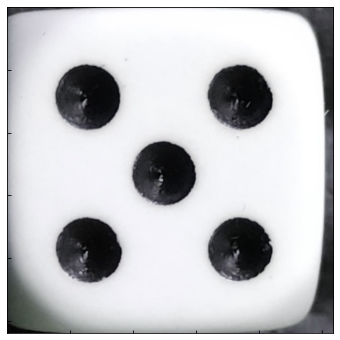

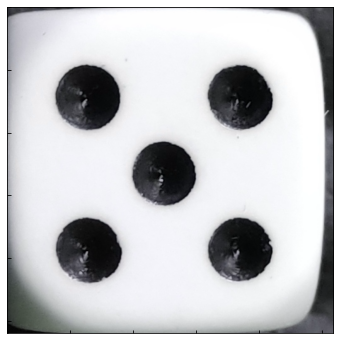

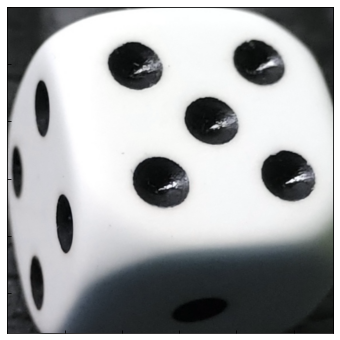

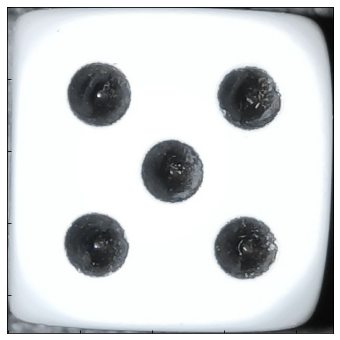

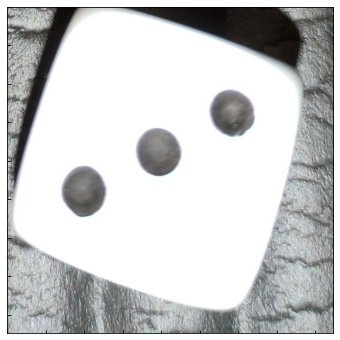

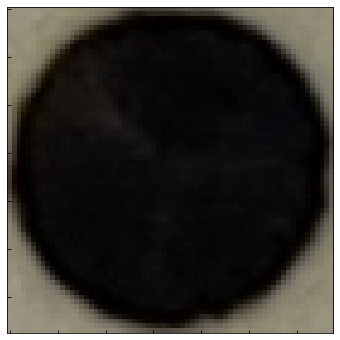

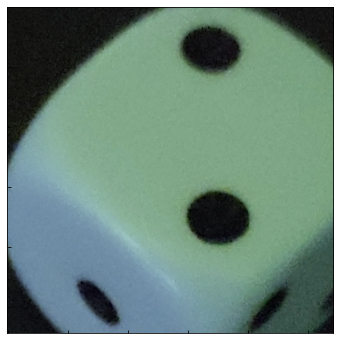

In [42]:
for i in range(0,7):
    figure(figsize=(6,6))
    ax = subplot(1,1,1)
    ax.tick_params(direction='in',labelleft=False, labelbottom = False, labelright = False)
    plt.imshow(latwe_zoomed[i][0])
    cv.imwrite("../zoomed/latwe{}_zoom.jpg".format(i), latwe_zoomed[i][0])

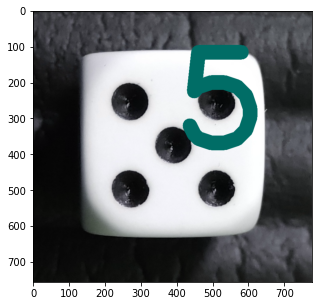

In [13]:
img = cv.imread('../zoomed/latwe0_zoom.jpg', 0)
showPipsCount(img,latwe0,latwe0_coords,500,20)

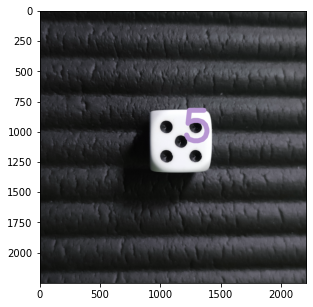

In [14]:
img = cv.imread('../zoomed/latwe1_zoom.jpg', 0)
showPipsCount(img,latwe1,latwe1_coords,300,20)

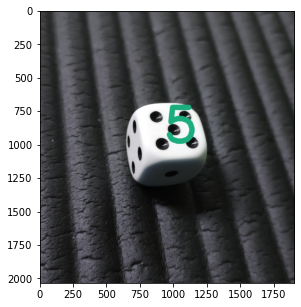

In [15]:
img = cv.imread('../zoomed/latwe2_zoom.jpg', 0)
showPipsCount(img,latwe2,latwe2_coords,300,22)

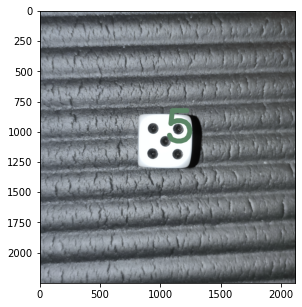

In [16]:
img = cv.imread('../zoomed/latwe3_zoom.jpg', 0)
showPipsCount(img,latwe3,latwe3_coords,300,25)

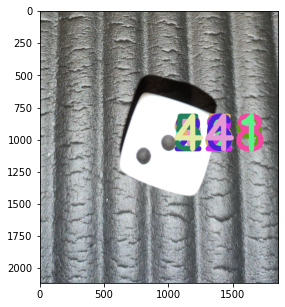

In [61]:
img = cv.imread('../zoomed/latwe4_zoom.jpg', 0)
showPipsCount(img,latwe4,latwe4_coords,175,25)

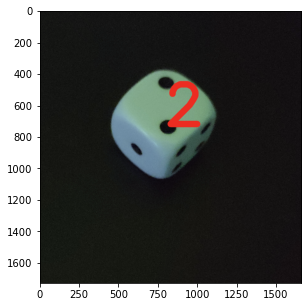

In [18]:
img = cv.imread('../zoomed/latwe5_zoom.jpg', 0)
showPipsCount(img,latwe5,latwe5_coords,200,14)

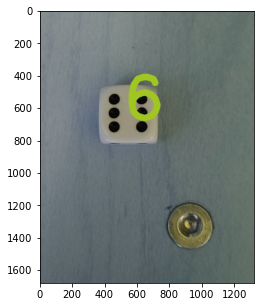

In [19]:
img = cv.imread('../zoomed/latwe6_zoom.jpg', 0)
showPipsCount(img,latwe6,latwe6_coords,200,14)

In [20]:
img = cv.imread('../zoomed/latwe7_zoom.jpg', 0)
showPipsCount(img,latwe7,latwe7_coords,300,20)

NameError: name 'latwe7' is not defined

In [ ]:
img = cv.imread('../zoomed/latwe8_zoom.jpg', 0)
showPipsCount(img,latwe8,latwe8_coords,500,20)

In [ ]:
img = cv.imread('../zoomed/latwe9_zoom.jpg', 0)
showPipsCount(img,latwe9,latwe9_coords, 200,15)

In [ ]:
sredni0 = Load.imgio('sredni0')
sredni0_zoomed, sredni0_coords = zoom(sredni0,35)
sredni_zoomed = [sredni0_zoomed]


In [ ]:
for i in range(1):
    for j in range(len(sredni_zoomed[i])):
        figure(figsize=(5,5))
        ax = subplot(1,1,1)
        ax.tick_params(direction='in',labelleft=False, labelbottom = False, labelright = False)
        plt.imshow(sredni_zoomed[i][j])
        plt.savefig("../zoomed/sredni{}_{}_zoom.jpg".format(i,j))

In [ ]:
for i in range(1):
    for j in range(len(sredni_zoomed[i])):
        img = cv.imread('../zoomed/sredni{}_{}_zoom.jpg'.format(i,j), 0)
        showPipsCountMultiDices(img,sredni0,sredni0_coords[j],300,25,j+1,len(sredni_zoomed[i]))

31


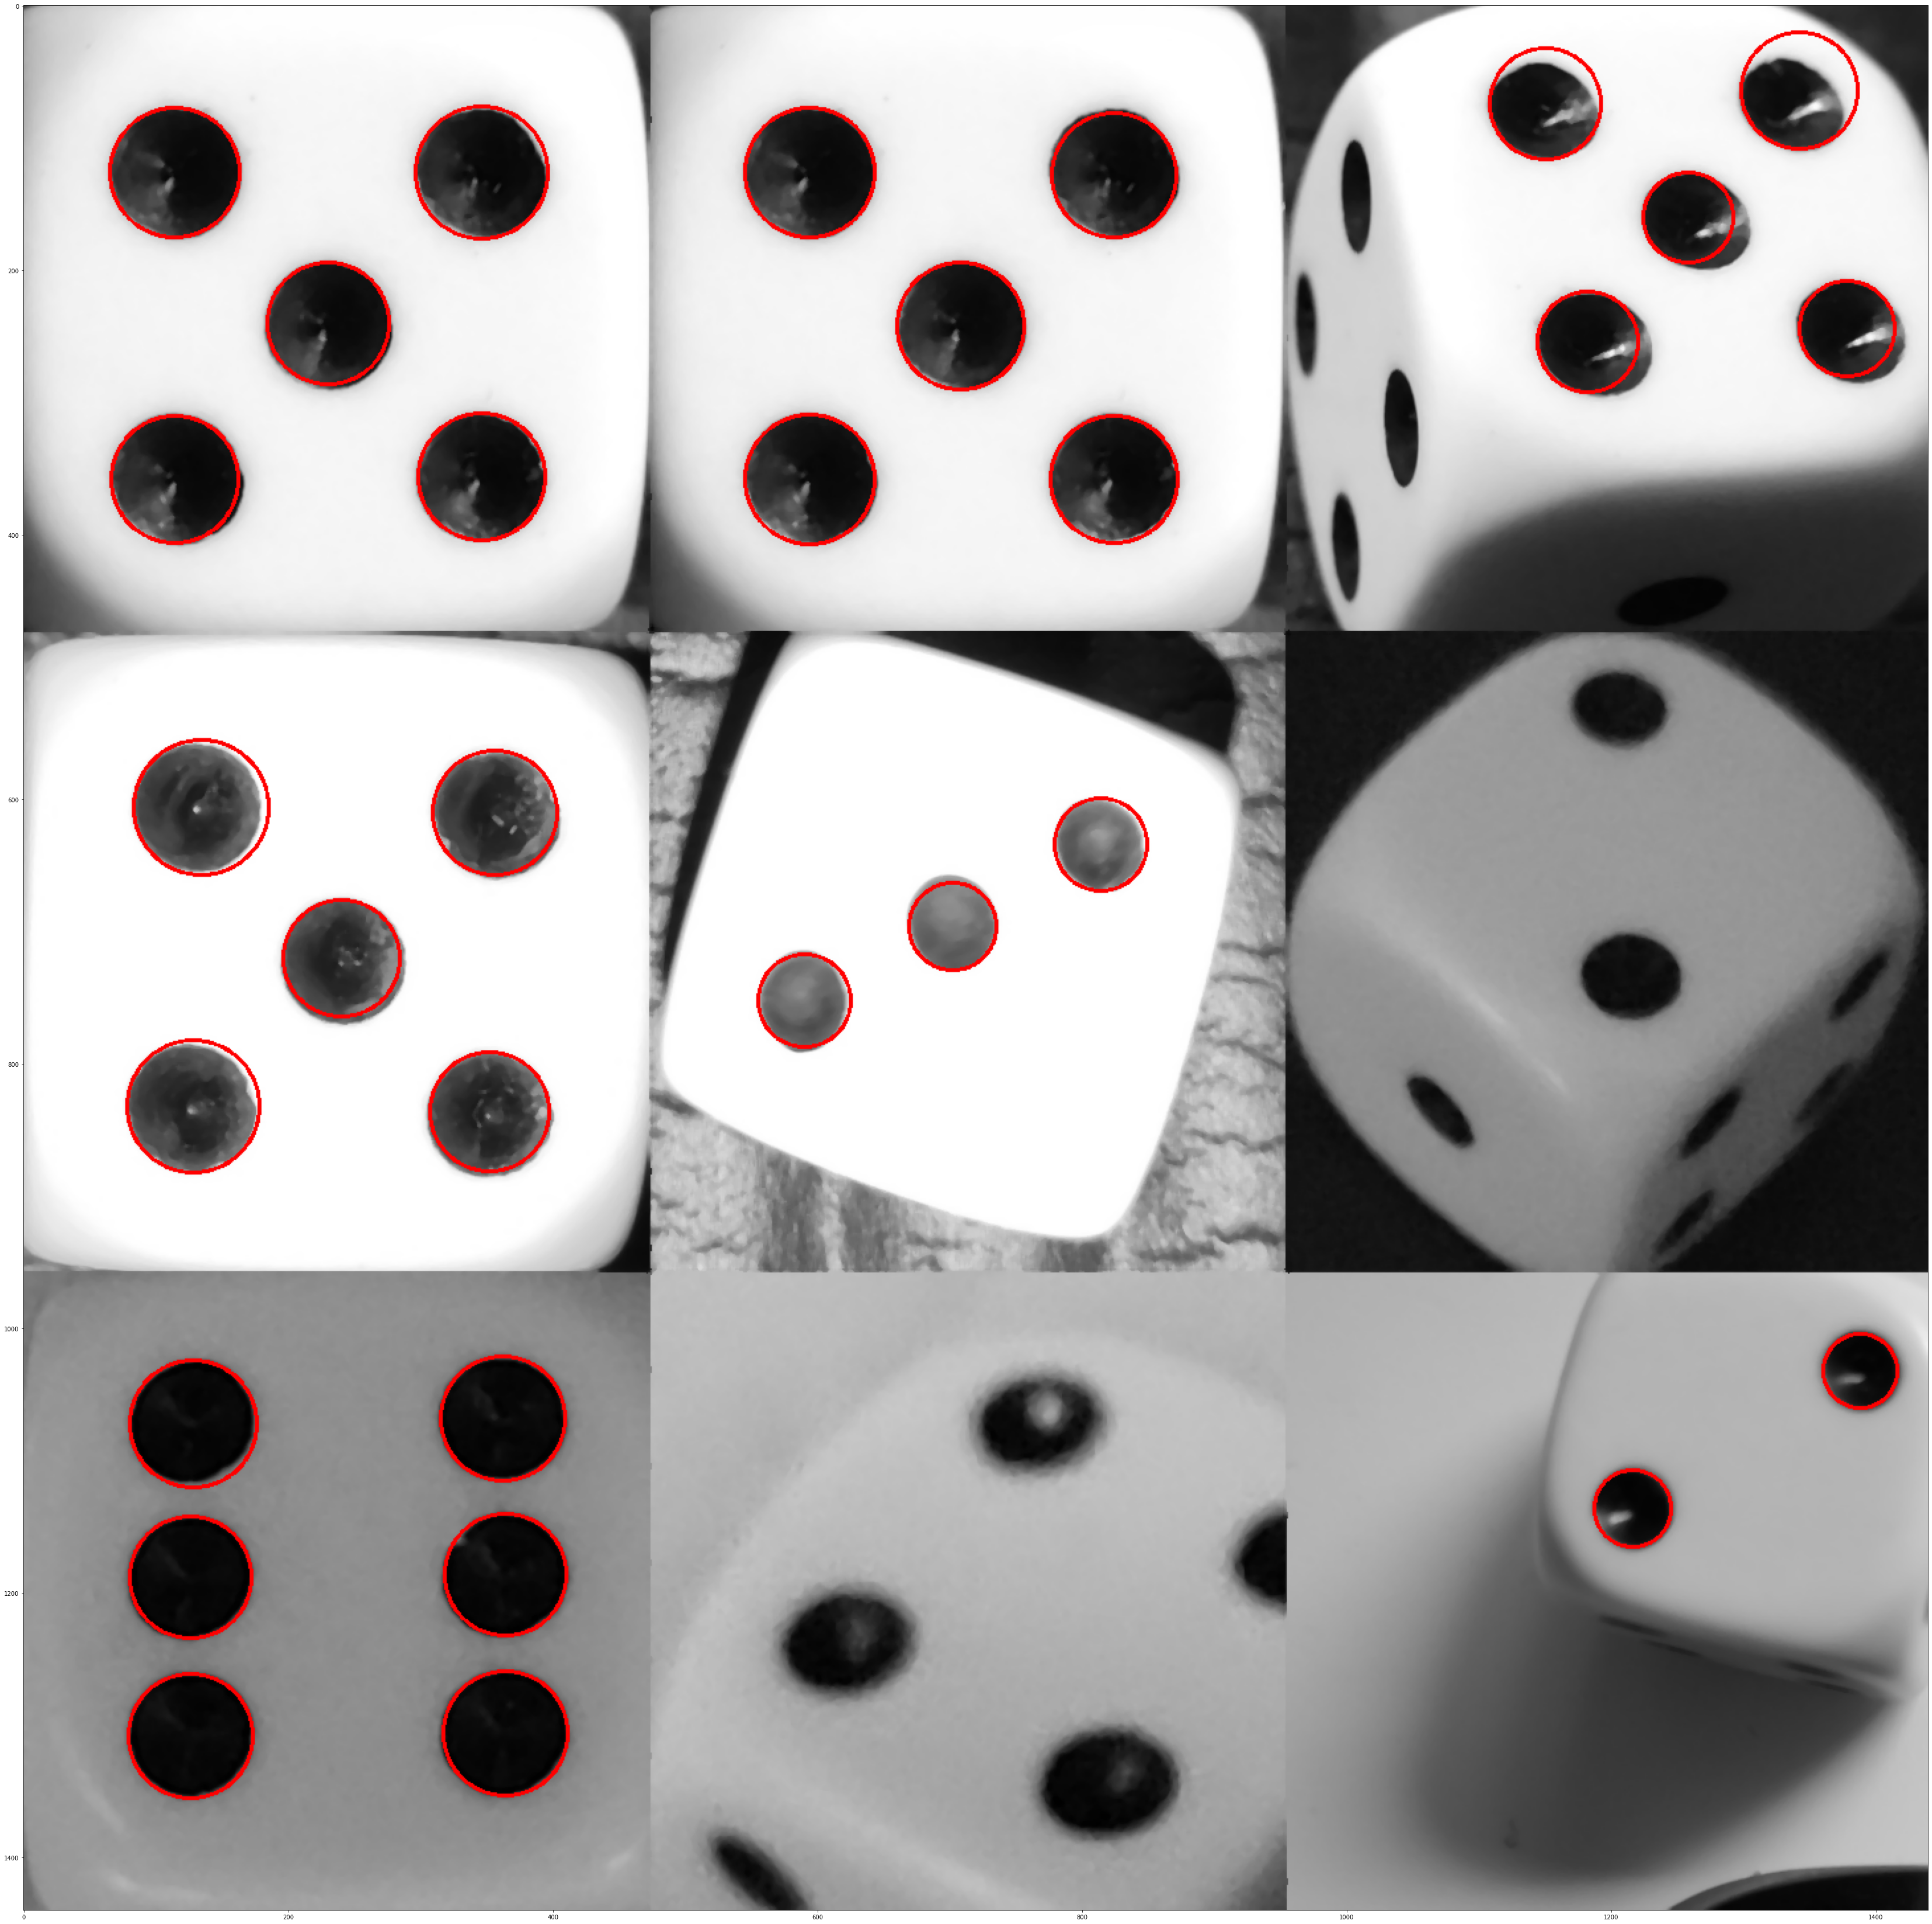

In [21]:
img = cv.imread('../zoomed/zooms.jpg', 0)
img = cv.medianBlur(img,5)
cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1,20,
                            param1=300,param2=25,minRadius=0,maxRadius=60)
circles = np.uint16(np.around(circles))
print(len(circles[0]))
font = cv.FONT_HERSHEY_SIMPLEX
j = 0
#print(circles)
for i in circles[0,:]:
    # draw the outer circle
    cv.circle(cimg,(i[0],i[1]),i[2],(255,0,0),2)
    # draw the center of the circle
    #cv.circle(cimg,(i[0],i[1]),2,(255,0,0),3)
    bottomLeftCornerOfText = (i[0], i[1])
    fontScale = 1
    fontColor = (0, 255, 0)
    lineType = 2
    output = ('#{}'.format(j))
    #cv.putText(cimg, output, bottomLeftCornerOfText, font, fontScale,fontColor,lineType)
    j+=1
    
figure(figsize=(60,60))
plt.imshow(cimg)
plt.savefig("../zoomed/oczka.jpg")